In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.experimental.numpy as tfnp
import xarray as xr
import numpy as np

In [2]:
# Load data
train_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/train_data.nc")
validation_ds = xr.open_dataset("/glade/scratch/lverhoef/gdl_toy_ds/validation_data.nc").isel(p=slice(0, 1000))

In [3]:
X_train = tf.expand_dims(tf.convert_to_tensor(train_ds['ellipse']), axis=-1)
Y_train = tf.convert_to_tensor(train_ds[['maj_len', 'min_len']].to_array().transpose())

2022-06-09 12:40:18.679252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 12:40:19.278278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [4]:
X_val = tf.expand_dims(tf.convert_to_tensor(validation_ds['ellipse']), axis=-1)
Y_val = tf.convert_to_tensor(validation_ds[['maj_len', 'min_len']].to_array().transpose())

In [12]:
# Layer that implements 4 discrete rotational equivariance
# Note that this uses group convolution on Z^2 x C_4, where rotation is about the center of the domain.
class RotEquivConv2D(tf.keras.layers.Layer):
    def __init__(self, out_features, filt_shape, rot_axis=True, activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.filt_shape = filt_shape
        self.rot_axis = rot_axis
        self.activation = activation

    def build(self, input_shape):  # Create the layer when it is first called
        self.in_features = input_shape[-1]
        self.filt_shape = tf.concat([
            self.filt_shape,  # Spatial dimensions
            [self.in_features, self.out_features]
        ], axis=0)
        self.filt_base = tf.Variable(
            tf.random.normal(self.filt_shape)  # Random initialization of filters
        )

    def call(self, inputs):  # Does the actual computation for each rotation
        if self.rot_axis:  # If we're already in Z^2 x C_4, convolve along each rotational layer
            return self.activation(tf.stack([
                    tf.nn.convolution(
                        tfnp.take(inputs, i, axis=-2),
                        self.filt_base)
                    for i in range(inputs.shape[-2])],
                axis=-2
            ))
        else:  # If we're not yet in the group domain, move to it.
            return self.activation(tf.stack([
                tf.nn.convolution(inputs, self.filt_base),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=1)), k=4-1, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=2)), k=4-2, axes=(1, 2)),
                tfnp.rot90(tf.nn.convolution(inputs, tfnp.rot90(self.filt_base, k=3)), k=4-3, axes=(1, 2)),
            ], axis=-2))

In [6]:
# 2D pooling layer that pools within each rotational dimension
class RotEquivPool2D(tf.keras.layers.Layer):
    def __init__(self, pool_size, pool_method=tf.keras.layers.MaxPool2D, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.pool_method = pool_method
        self.pool = self.pool_method(pool_size=self.pool_size)

    def call(self, inputs):
        return tf.stack(
            [self.pool(tfnp.take(inputs, k, axis=-2)) for k in range(inputs.shape[-2])],
            axis=-2
        )

In [7]:
# Rotational invariant pooling that pools across the rotational dimensions
class RotInvPool(tf.keras.layers.Layer):
    def __init__(self, pool_method='max', **kwargs):
        valid_methods = {'max', 'mean'}
        if pool_method not in valid_methods:
            raise ValueError(f'pool_method must be one of {valid_methods}')

        super().__init__(**kwargs)
        if pool_method == "max":
            self.pool_method = tf.math.reduce_max
        else:
            self.pool_method = tf.math.reduce_mean

    def call(self, inputs):
        return self.pool_method(inputs, axis=-2)

In [13]:
model = models.Sequential()
model.add(RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(128, 128, 1)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(32, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(64, (3, 3)))
model.add(RotEquivPool2D((2, 2)))
model.add(RotEquivConv2D(128, (3, 3)))
model.add(RotInvPool())
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(2))

In [14]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_5 (RotEqui  (None, 126, 126, 4, 32)  288       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_4 (RotEqui  (None, 63, 63, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_6 (RotEqui  (None, 61, 61, 4, 32)    9216      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_5 (RotEqui  (None, 30, 30, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_7 (RotEqui  (None, 28, 28, 4, 64)   

In [16]:
history = model.fit(
    x=X_train, y=Y_train,
    epochs=10, validation_data=(X_val, Y_val),
    shuffle=True
)

Epoch 1/10
313/313 [==============================] - 23s 52ms/step - loss: 2985906432.0000 - mse: 2985906432.0000 - val_loss: 45799532.0000 - val_mse: 45799532.0000
Epoch 2/10
313/313 [==============================] - 15s 49ms/step - loss: 31421164.0000 - mse: 31421164.0000 - val_loss: 34756716.0000 - val_mse: 34756716.0000
Epoch 3/10
313/313 [==============================] - 15s 49ms/step - loss: 22659838.0000 - mse: 22659838.0000 - val_loss: 23263164.0000 - val_mse: 23263164.0000
Epoch 4/10
313/313 [==============================] - 16s 51ms/step - loss: 17967226.0000 - mse: 17967226.0000 - val_loss: 17424216.0000 - val_mse: 17424216.0000
Epoch 5/10
313/313 [==============================] - 15s 49ms/step - loss: 15195202.0000 - mse: 15195202.0000 - val_loss: 17921080.0000 - val_mse: 17921080.0000
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 13209145.0000 - mse: 13209145.0000 - val_loss: 13468326.0000 - val_mse: 13468326.0000
Epoch 7/10
313/313 [====

<xarray.Dataset>
Dimensions:  ()
Data variables:
    maj_len  float64 30.39
    min_len  float64 16.28

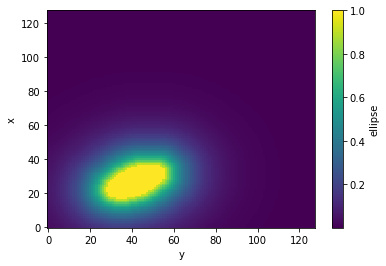

In [19]:
validation_ds['ellipse'][0, :, :].plot()
validation_ds[['maj_len', 'min_len']].sel(p=0)

In [25]:
model.predict(X_val[0:10, :, :, :])

1/1 [==============================] - 1s 521ms/step


array([[ -196.36255, -3783.9785 ],
       [ 2513.4675 , -2681.965  ],
       [ 1925.9973 , -1105.4064 ],
       [  450.1902 , -6742.0693 ],
       [ 5250.399  , -5242.8047 ],
       [  531.198  , -1264.6464 ],
       [-1458.4153 , -3258.9714 ],
       [  131.00464,  1333.4086 ],
       [ 3093.7283 , -4404.597  ],
       [-2987.8723 , -3708.5217 ]], dtype=float32)

In [26]:
del X_train